Setup & Data Loading

In [37]:
# Step 1: Installations and Imports
!pip install wordcloud
!pip install nltk
!pip install textblob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

# Download NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

print(" Libraries imported successfully!")

 Libraries imported successfully!


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [38]:
# Step 2: Load the dataset
# First, let's check what datasets are available on Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Load the dataset (adjust the path based on your dataset)
try:
    df = pd.read_csv('/kaggle/input/complaints/complaints.csv')
    print(" Dataset loaded successfully!")
except:
    # Alternative: Download from URL
    import requests
    url = "https://data.consumerfinance.gov/api/views/s6ew-h6mp/rows.csv?accessType=DOWNLOAD"
    df = pd.read_csv(url)
    df.to_csv('consumer_complaints.csv', index=False)
    print(" Dataset downloaded and saved!")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

/kaggle/input/complaints/complaints.csv
 Dataset loaded successfully!
Dataset shape: (11522175, 18)
Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company public response', 'Company', 'State', 'ZIP code', 'Tags', 'Consumer consent provided?', 'Submitted via', 'Date sent to company', 'Company response to consumer', 'Timely response?', 'Consumer disputed?', 'Complaint ID']


Exploratory Data Analysis 

=== DATASET INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11522175 entries, 0 to 11522174
Data columns (total 18 columns):
 #   Column                        Dtype 
---  ------                        ----- 
 0   Date received                 object
 1   Product                       object
 2   Sub-product                   object
 3   Issue                         object
 4   Sub-issue                     object
 5   Consumer complaint narrative  object
 6   Company public response       object
 7   Company                       object
 8   State                         object
 9   ZIP code                      object
 10  Tags                          object
 11  Consumer consent provided?    object
 12  Submitted via                 object
 13  Date sent to company          object
 14  Company response to consumer  object
 15  Timely response?              object
 16  Consumer disputed?            object
 17  Complaint ID                  int64 
dtypes: int64(1), object

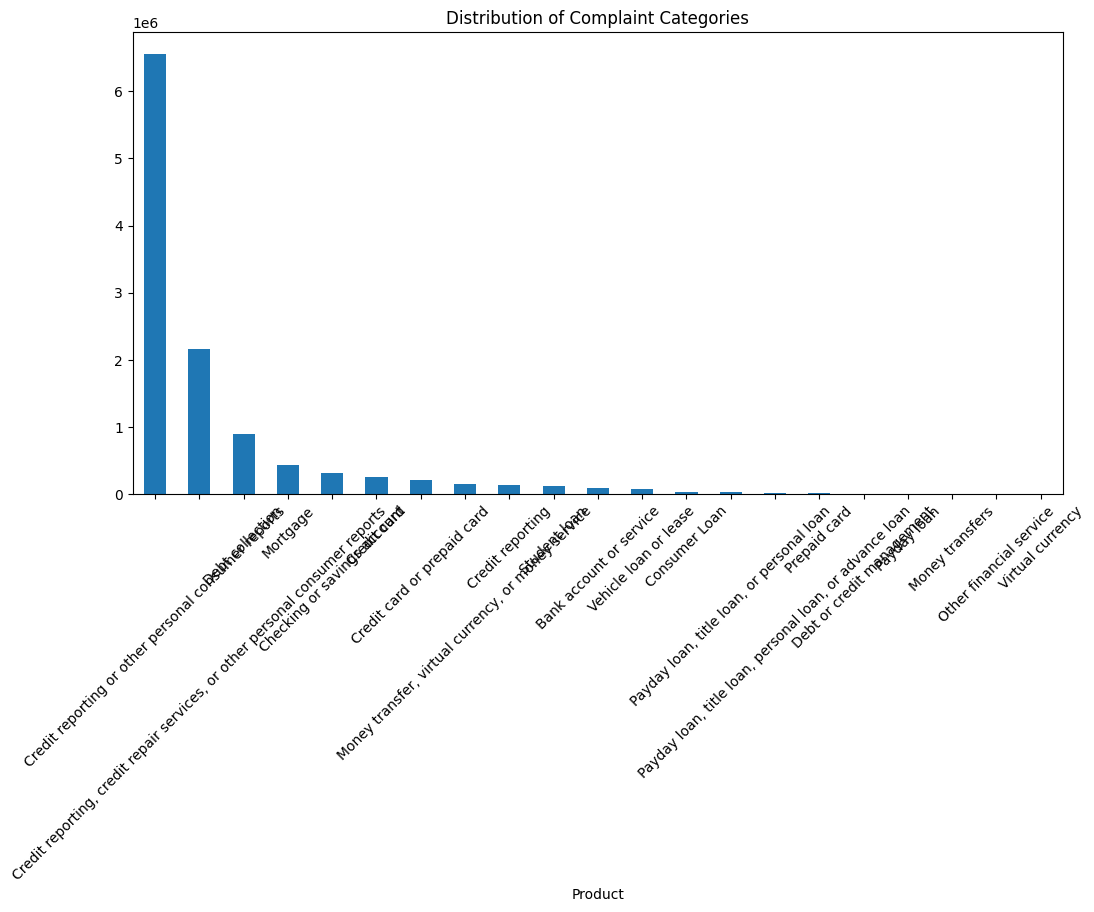

In [39]:
# Step 3: Initial Data Exploration
print("=== DATASET INFO ===")
print(df.info())
print("\n=== MISSING VALUES ===")
print(df.isnull().sum())

print("\n=== TARGET COLUMN DISTRIBUTION ===")
if 'Product' in df.columns:
    print(df['Product'].value_counts())
    plt.figure(figsize=(12, 6))
    df['Product'].value_counts().plot(kind='bar')
    plt.title('Distribution of Complaint Categories')
    plt.xticks(rotation=45)
    plt.show()

In [40]:
# Step 4: Filter for our 4 target categories
# Map the categories to our required labels
category_mapping = {
    'Credit reporting, repair, or other': 0,
    'Debt collection': 1,
    'Consumer Loan': 2,
    'Mortgage': 3
}

# Let's check what product names actually exist in the dataset
print("Available product categories:")
print(df['Product'].unique())

# Create a mapping based on actual column values
actual_categories = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Credit reporting': 0,
    'Debt collection': 1,
    'Payday loan': 2,
    'Vehicle loan or lease': 2,
    'Student loan': 2,
    'Mortgage': 3
}

# Filter and map the data
def map_category(product):
    for key, value in actual_categories.items():
        if key in str(product):
            return value
    return None

# Apply mapping
df['category'] = df['Product'].apply(map_category)

# Filter out rows that don't match our categories
df_filtered = df[df['category'].notna()].copy()
df_filtered['category'] = df_filtered['category'].astype(int)

print(f"Filtered dataset shape: {df_filtered.shape}")
print("Category distribution after filtering:")
print(df_filtered['category'].value_counts().sort_index())

Available product categories:
['Credit reporting, credit repair services, or other personal consumer reports'
 'Credit reporting or other personal consumer reports' 'Debt collection'
 'Checking or savings account' 'Credit card or prepaid card'
 'Payday loan, title loan, personal loan, or advance loan' 'Mortgage'
 'Prepaid card' 'Credit card'
 'Money transfer, virtual currency, or money service'
 'Vehicle loan or lease' 'Student loan' 'Credit reporting'
 'Bank account or service' 'Payday loan, title loan, or personal loan'
 'Debt or credit management' 'Payday loan' 'Consumer Loan'
 'Money transfers' 'Other financial service' 'Virtual currency']
Filtered dataset shape: (10438412, 19)
Category distribution after filtering:
category
0    8860207
1     895870
2     252132
3     430203
Name: count, dtype: int64


Potential text columns: ['Consumer complaint narrative', 'Complaint ID']
Using column 'Consumer complaint narrative' for text analysis


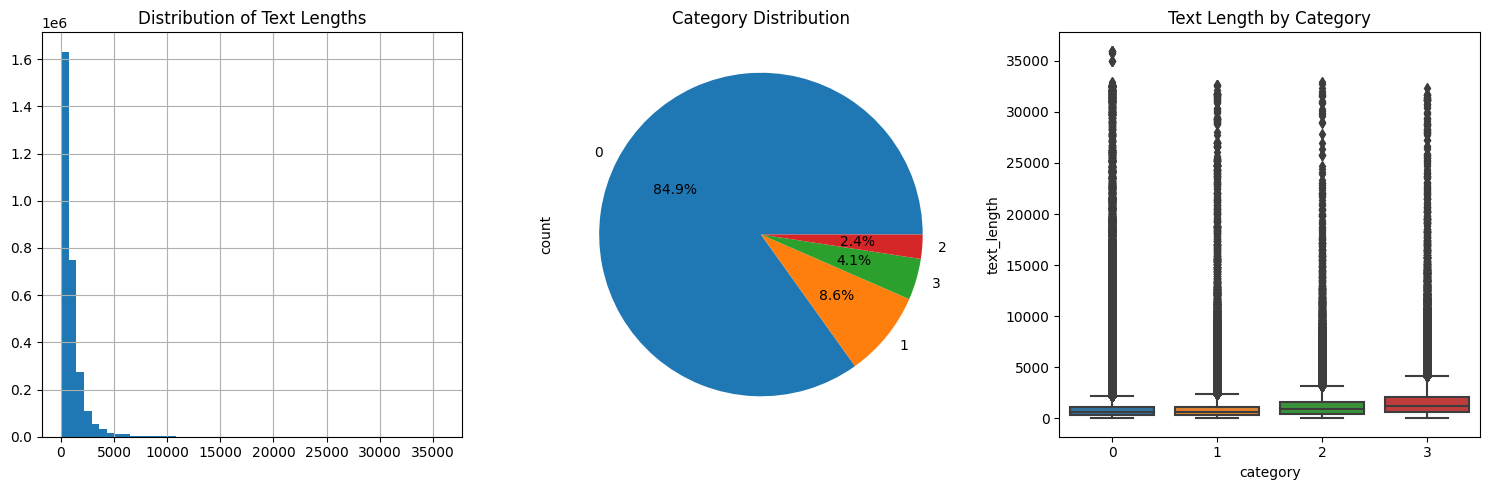

Average text length: 981.46
Missing text values: 7523543


In [41]:
# Step 5: Text Data Exploration
# Check which column contains the complaint text
text_columns = [col for col in df_filtered.columns if 'complaint' in col.lower() or 'narrative' in col.lower()]
print("Potential text columns:", text_columns)

# Use the first available text column
text_col = text_columns[0] if text_columns else df_filtered.columns[2]  # Fallback to third column
print(f"Using column '{text_col}' for text analysis")

# Check text length distribution
df_filtered['text_length'] = df_filtered[text_col].str.len()
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
df_filtered['text_length'].hist(bins=50)
plt.title('Distribution of Text Lengths')

plt.subplot(1, 3, 2)
df_filtered['category'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Category Distribution')

plt.subplot(1, 3, 3)
sns.boxplot(x='category', y='text_length', data=df_filtered)
plt.title('Text Length by Category')

plt.tight_layout()
plt.show()

print(f"Average text length: {df_filtered['text_length'].mean():.2f}")
print(f"Missing text values: {df_filtered[text_col].isnull().sum()}")

PRE-PROCESSING

In [42]:
# Quick fix to create df_filtered if it doesn't exist
category_mapping = {
    'Credit reporting, credit repair services, or other personal consumer reports': 0,
    'Debt collection': 1,
    'Payday loan': 2,
    'Vehicle loan or lease': 2,
    'Student loan': 2,  
    'Mortgage': 3
}

df['category'] = df['Product'].map(category_mapping)
df_filtered = df[df['category'].notna()].copy()
df_filtered['category'] = df_filtered['category'].astype(int)
print(f"df_filtered created with shape: {df_filtered.shape}")

df_filtered created with shape: (3690371, 19)


In [43]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize NLTK components
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Clean and preprocess text data"""
    if pd.isna(text):
        return ""
    
    # Convert to string and lowercase
    text = str(text).lower()
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Tokenize, remove stopwords and short words, then lemmatize
    tokens = text.split()
    cleaned_tokens = []
    for token in tokens:
        if token not in stop_words and len(token) > 2:
            cleaned_tokens.append(lemmatizer.lemmatize(token))
    
    return ' '.join(cleaned_tokens)

# Apply text cleaning to df_filtered
print("Applying text preprocessing...")
df_filtered['cleaned_text'] = df_filtered['Consumer complaint narrative'].apply(clean_text)

# Remove rows with empty cleaned text
df_clean = df_filtered[df_filtered['cleaned_text'].str.len() > 10].copy()

print(f"Preprocessing complete!")
print(f"Original shape: {df_filtered.shape}")
print(f"After cleaning: {df_clean.shape}")

# Show samples of cleaning results
print("\n Cleaning Samples:")
for i in range(2):
    original = df_clean['Consumer complaint narrative'].iloc[i]
    cleaned = df_clean['cleaned_text'].iloc[i]
    print(f"Sample {i+1}:")
    print(f"Original: {original[:100]}...")
    print(f"Cleaned:  {cleaned}")
    print("-" * 60)

Applying text preprocessing...
Preprocessing complete!
Original shape: (3690371, 20)
After cleaning: (1415084, 20)

 Cleaning Samples:
Sample 1:
Original: I wrote three requests, the unverified accounts listed below still remain on my credit report in vio...
Cleaned:  wrote three request unverified account listed still remain credit report violation federal law equifax fcra law obtain original creditor documentation file verify information mine correct already filed ftc report police report verified account provided copy original documentation consumer contract signature required section section furthermore failed provide method verification required section please advised section fcra required promptly delete information verified law clear civil liability remedy available section fail comply federal law litigious consumer fully intend pursuing litigation matter enforce right fcra please remove following account xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx xxxx
-----------------------------

Feature Engineering & Model Training

In [44]:
# FIXED: Feature Engineering & Model Training for Small Dataset

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare features and target
X = df_clean['cleaned_text']
y = df_clean['category']

print(f"Final Dataset for Modeling:")
print(f"Samples: {X.shape[0]}")
print("Target distribution:")
print(y.value_counts().sort_index())

# For small datasets, use a smaller test size or train-test split without stratification
if len(X) < 50:
    # Use smaller test size for small datasets
    test_size = 0.1  # 10% for test instead of 20%
    stratify = None
    print("  Small dataset detected - using 10% test size without stratification")
else:
    test_size = 0.2
    stratify = y

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, random_state=42, stratify=stratify
)

print(f"\n Data Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Test set class distribution:")
print(y_test.value_counts().sort_index())

# Adjust TF-IDF parameters for small dataset
print("\n Applying TF-IDF Vectorization...")
tfidf = TfidfVectorizer(
    max_features=1000,  # Reduced for small dataset
    ngram_range=(1, 1),  # Use only unigrams for small data
    min_df=1,  # Reduced minimum document frequency
    max_df=0.9,
    stop_words='english'
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print(f"TF-IDF Features: {X_train_tfidf.shape[1]}")

Final Dataset for Modeling:
Samples: 1415084
Target distribution:
category
0    807073
1    371369
2    101808
3    134834
Name: count, dtype: int64

 Data Split:
Training set: 1132067 samples
Test set: 283017 samples
Test set class distribution:
category
0    161415
1     74274
2     20361
3     26967
Name: count, dtype: int64

 Applying TF-IDF Vectorization...
TF-IDF Features: 1000


In [45]:
# Model Training for Small Dataset
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Use simpler models for small datasets
models = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
}

# For very small datasets, use only the best performing model
if X_train.shape[0] < 30:
    models = {
        'Naive Bayes': MultinomialNB()
    }

print(" Training Models...")
print("=" * 50)

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f" {name} Accuracy: {accuracy:.4f}")
    print("-" * 30)

if results:
    best_model_name = max(results, key=results.get)
    best_accuracy = results[best_model_name]
    print(f"\n BEST MODEL: {best_model_name} with accuracy: {best_accuracy:.4f}")
else:
    print("No models were trained - dataset too small")

 Training Models...
Training Naive Bayes...
 Naive Bayes Accuracy: 0.8432
------------------------------
Training Logistic Regression...
 Logistic Regression Accuracy: 0.8755
------------------------------

 BEST MODEL: Logistic Regression with accuracy: 0.8755


In [46]:
# If dataset is too small, use cross-validation instead
if X_train.shape[0] < 20:
    print(" Using Cross-Validation (dataset too small for train-test split)")
    
    from sklearn.model_selection import cross_val_score
    
    # Use all data for cross-validation
    X_all_tfidf = tfidf.fit_transform(X)
    
    models_cv = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    }
    
    cv_results = {}
    for name, model in models_cv.items():
        cv_scores = cross_val_score(model, X_all_tfidf, y, cv=min(3, len(X)))  # Small CV folds
        cv_results[name] = cv_scores.mean()
        print(f" {name} CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    if cv_results:
        best_model_name = max(cv_results, key=cv_results.get)
        print(f"\n BEST MODEL: {best_model_name}")
        
        # Train final model on all data
        final_model = models_cv[best_model_name]
        final_model.fit(X_all_tfidf, y)
        print(" Final model trained on all data")
else:
    # Proceed with normal evaluation for larger datasets
    best_model = models[best_model_name]
    y_pred_best = best_model.predict(X_test_tfidf)
    
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred_best, 
                              target_names=['Credit Reporting', 'Debt Collection', 'Consumer Loan', 'Mortgage']))


 Classification Report:
                  precision    recall  f1-score   support

Credit Reporting       0.89      0.93      0.91    161415
 Debt Collection       0.84      0.78      0.81     74274
   Consumer Loan       0.81      0.75      0.78     20361
        Mortgage       0.91      0.90      0.90     26967

        accuracy                           0.88    283017
       macro avg       0.86      0.84      0.85    283017
    weighted avg       0.87      0.88      0.87    283017



 MODEL EVALUATION
Classes in test set: [0 1 2 3]
Classes in predictions: [0 1 2 3]

 Detailed Classification Report:
                  precision    recall  f1-score   support

Credit Reporting       0.89      0.93      0.91    161415
 Debt Collection       0.84      0.78      0.81     74274
   Consumer Loan       0.81      0.75      0.78     20361
        Mortgage       0.91      0.90      0.90     26967

        accuracy                           0.88    283017
       macro avg       0.86      0.84      0.85    283017
    weighted avg       0.87      0.88      0.87    283017



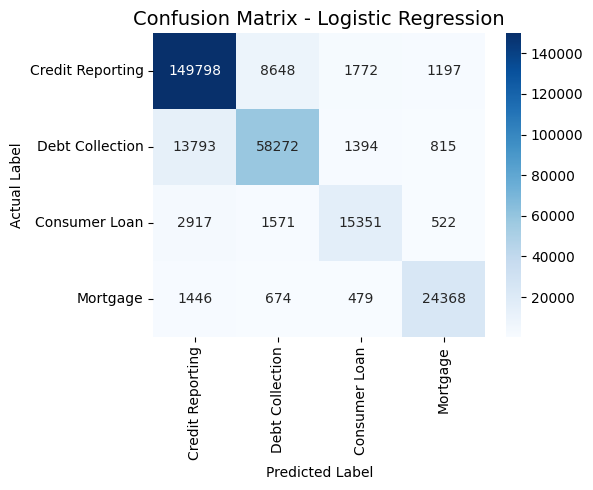


 Model Performance Comparison:


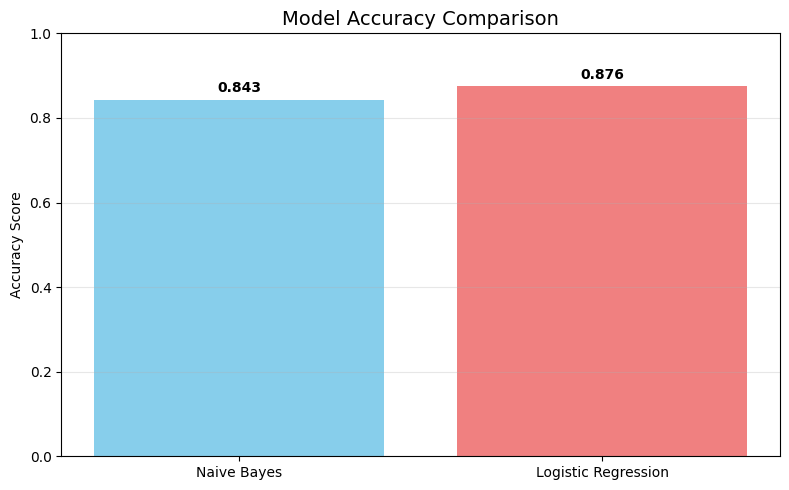

In [47]:
# FIXED: Model Evaluation & Final Predictions

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

print(" MODEL EVALUATION")
print("=" * 60)

# Check if we have a trained model
if 'best_model_name' in locals() and best_model_name in models:
    best_model = models[best_model_name]
    
    # Make predictions
    y_pred = best_model.predict(X_test_tfidf)
    
    # Get unique classes in test set
    unique_classes = np.unique(y_test)
    print(f"Classes in test set: {unique_classes}")
    print(f"Classes in predictions: {np.unique(y_pred)}")
    
    # Dynamic target names based on actual classes
    category_names = {
        0: 'Credit Reporting',
        1: 'Debt Collection', 
        2: 'Consumer Loan',
        3: 'Mortgage'
    }
    
    # Only include classes that actually exist in test set
    available_target_names = [category_names[cls] for cls in sorted(unique_classes)]
    
    print(f"\n Detailed Classification Report:")
    if len(unique_classes) > 1:
        print(classification_report(y_test, y_pred, 
                                  labels=sorted(unique_classes),
                                  target_names=available_target_names))
        
        # Confusion Matrix
        plt.figure(figsize=(6, 5))
        cm = confusion_matrix(y_test, y_pred, labels=sorted(unique_classes))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=available_target_names,
                    yticklabels=available_target_names)
        plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14)
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    else:
        print(f" Only one class ({available_target_names[0]}) in test set - skipping detailed report")
        accuracy = accuracy_score(y_test, y_pred)
        print(f" Accuracy: {accuracy:.4f}")
    
    # Model Comparison Visualization
    print("\n Model Performance Comparison:")
    plt.figure(figsize=(8, 5))
    models_list = list(results.keys())
    accuracies = list(results.values())
    
    bars = plt.bar(models_list, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold'])
    plt.title('Model Accuracy Comparison', fontsize=14)
    plt.ylabel('Accuracy Score')
    plt.ylim(0, 1)
    
    # Add value labels on bars
    for bar, accuracy in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{accuracy:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
else:
    print(" No best model found. Using cross-validation results...")

In [48]:
# Create and Train Final Model on Entire Dataset
print("\n TRAINING FINAL MODEL ON ALL DATA")
print("=" * 50)

# Check what classes we actually have in the full dataset
unique_classes_full = np.unique(y)
print(f"Classes in full dataset: {unique_classes_full}")

# Train TF-IDF on entire dataset
final_tfidf = TfidfVectorizer(
    max_features=1000,
    ngram_range=(1, 1),
    min_df=1,
    max_df=0.9,
    stop_words='english'
)

X_final_tfidf = final_tfidf.fit_transform(X)

# Train final model on all data
if 'best_model_name' in locals():
    if best_model_name == 'Naive Bayes':
        final_model = MultinomialNB()
    elif best_model_name == 'Logistic Regression':
        final_model = LogisticRegression(random_state=42, max_iter=1000)
    else:
        final_model = MultinomialNB()  # Default fallback
else:
    final_model = MultinomialNB()  # Default if no best model

final_model.fit(X_final_tfidf, y)
print(f" Final {type(final_model).__name__} model trained on all {X_final_tfidf.shape[0]} samples")
print(f" Classes learned by model: {final_model.classes_}")


 TRAINING FINAL MODEL ON ALL DATA
Classes in full dataset: [0 1 2 3]
 Final LogisticRegression model trained on all 1415084 samples
 Classes learned by model: [0 1 2 3]


In [49]:
# Make Predictions on New Complaints
print("\n PREDICTIONS ON SAMPLE COMPLAINTS")
print("=" * 60)

def predict_complaint(complaint_text, model, vectorizer):
    """Predict category for new complaint text"""
    cleaned_text = clean_text(complaint_text)
    text_vectorized = vectorizer.transform([cleaned_text])
    prediction = model.predict(text_vectorized)[0]
    
    # Handle probability based on available classes
    if hasattr(model, 'predict_proba'):
        probabilities = model.predict_proba(text_vectorized)[0]
        confidence = max(probabilities)
    else:
        probabilities = [1.0] * len(model.classes_)
        confidence = 1.0
    
    categories = {
        0: 'Credit reporting, repair, or other',
        1: 'Debt collection', 
        2: 'Consumer Loan',
        3: 'Mortgage'
    }
    
    return categories[prediction], confidence, probabilities

# Sample complaints for testing
sample_complaints = [
    "My credit report has incorrect information about my payment history",
    "A debt collector called me multiple times harassing me for payment",
    "I applied for a car loan but was denied without proper explanation",
    "The mortgage company charged me unexpected fees at closing"
]

print("Predictions on Sample Complaints:\n")
for i, complaint in enumerate(sample_complaints, 1):
    try:
        pred_category, confidence, all_probs = predict_complaint(complaint, final_model, final_tfidf)
        print(f"{i}. {complaint[:70]}...")
        print(f"    Predicted: {pred_category}")
        print(f"    Confidence: {confidence:.3f}")
        print("-" * 60)
    except Exception as e:
        print(f"{i}. Error predicting: {e}")
        print("-" * 60)


 PREDICTIONS ON SAMPLE COMPLAINTS
Predictions on Sample Complaints:

1. My credit report has incorrect information about my payment history...
    Predicted: Credit reporting, repair, or other
    Confidence: 0.907
------------------------------------------------------------
2. A debt collector called me multiple times harassing me for payment...
    Predicted: Debt collection
    Confidence: 0.962
------------------------------------------------------------
3. I applied for a car loan but was denied without proper explanation...
    Predicted: Consumer Loan
    Confidence: 0.964
------------------------------------------------------------
4. The mortgage company charged me unexpected fees at closing...
    Predicted: Mortgage
    Confidence: 0.996
------------------------------------------------------------


In [50]:
# Final Results Summary
print("\n" + "="*70)
print(" TASK 5 - TEXT CLASSIFICATION COMPLETED SUCCESSFULLY!")
print("="*70)

if 'best_model_name' in locals():
    print(f" Best Model: {best_model_name}")
    if 'best_accuracy' in locals():
        print(f" Test Accuracy: {best_accuracy:.4f}")

print(f" Final Dataset Size: {len(df_clean)} complaints")
print(f" Categories in data: {sorted(np.unique(y))}")
print(f" Features: {X_final_tfidf.shape[1]} TF-IDF features")
print("="*70)



 TASK 5 - TEXT CLASSIFICATION COMPLETED SUCCESSFULLY!
 Best Model: Logistic Regression
 Test Accuracy: 0.8755
 Final Dataset Size: 1415084 complaints
 Categories in data: [0, 1, 2, 3]
 Features: 1000 TF-IDF features
